In [1]:
%run Financial_Agent_Self_Eval.ipynb

In [2]:
model = update_router()

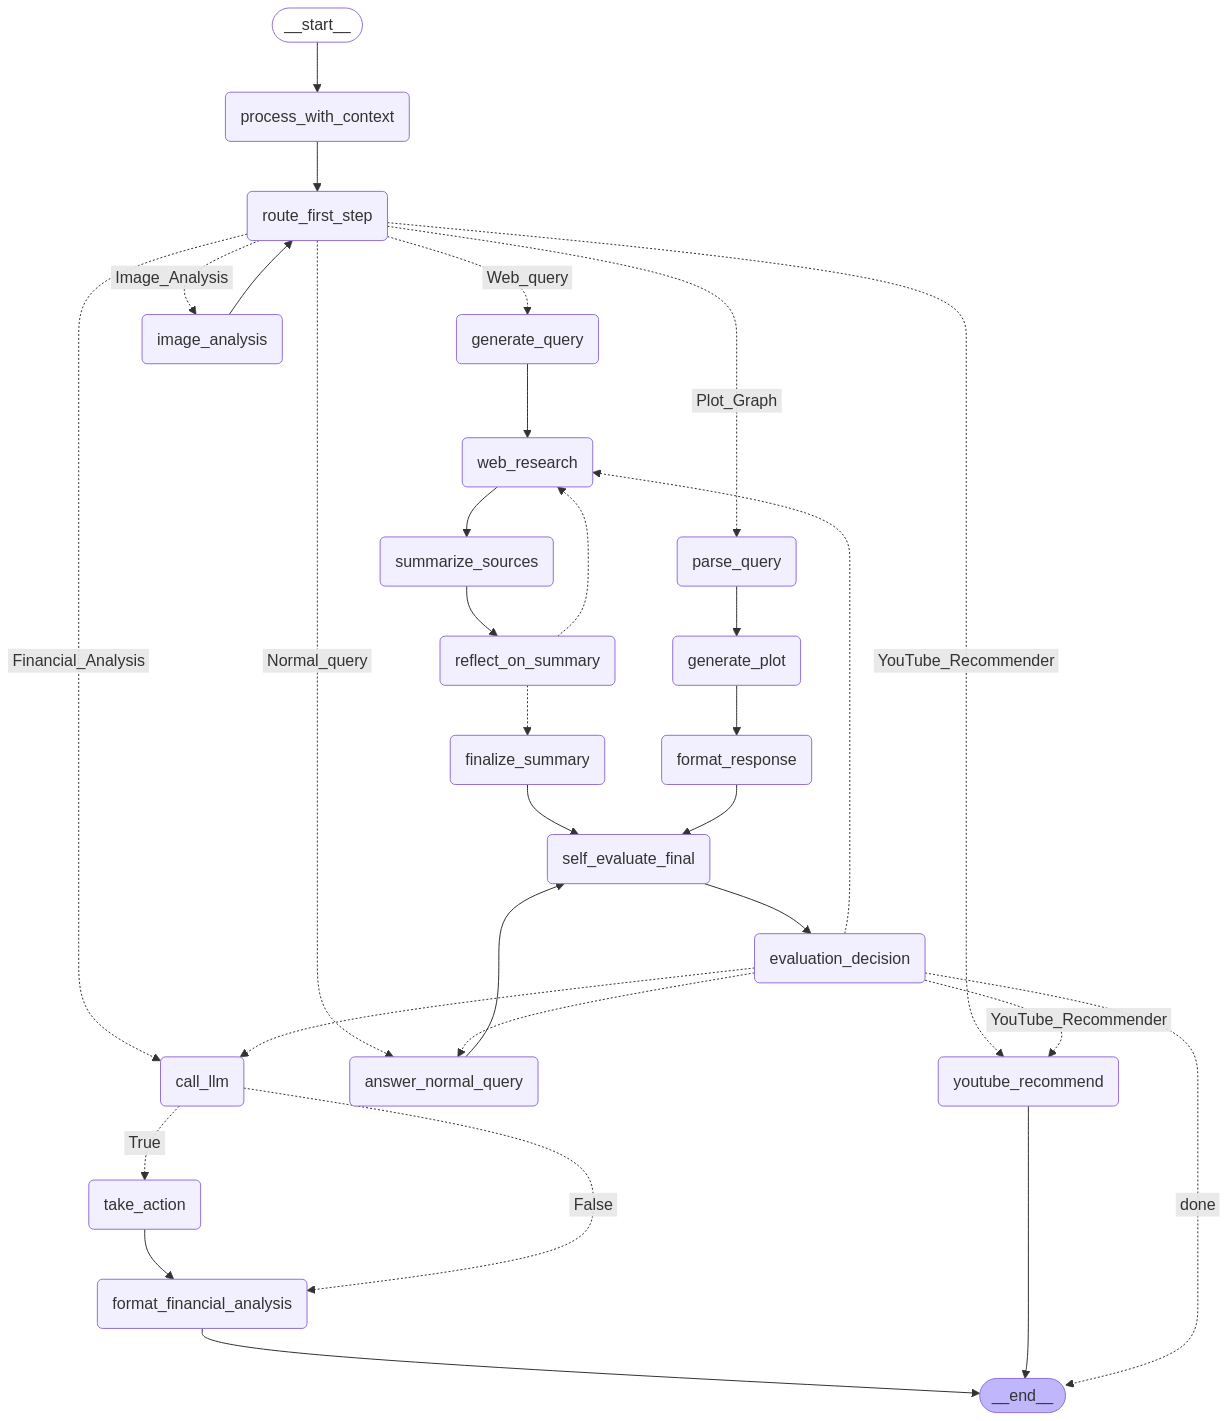

In [3]:
model

In [4]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.colors as pc
import yfinance as yf
import pandas as pd
import plotly.io as pio
from typing import TypedDict, Annotated, Optional
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage


In [5]:
class FinancialChatBot:
    def __init__(self):
        self.conversation_history = []
        self.model = update_router()
        
    def _format_bot_message(self, content: str) -> str:
        """Format the bot's message for display"""
        return f"🤖 Assistant: {content}"
    
    def _format_user_message(self, content: str) -> str:
        """Format the user's message for display"""
        return f"👤 User: {content}"
    
    def chat(self, user_input: str, image_path: str = None) -> str:
        """
        Process a single chat interaction
        
        Args:
            user_input (str): The user's message
            image_path (str, optional): Path to an image if one is provided
            
        Returns:
            str: The bot's response
        """
        # Add user message to history
        self.conversation_history.append(self._format_user_message(user_input))
        
        # Create initial state with image if provided
        image_list = [image_path] if image_path else []
        initial_state = create_initial_state(user_input, image_list)
        
        try:
            # Process through the model
            response = self.model.invoke(initial_state)
            
            # Extract the response from running_summary
            bot_response = response.get('running_summary', '')
            if not bot_response and response.get('messages'):
                # Fallback to last message content if running_summary is empty
                bot_response = response['messages'][-1].content
                
            # Format and store bot's response
            formatted_response = self._format_bot_message(bot_response)
            self.conversation_history.append(formatted_response)
            
            return bot_response
            
        except Exception as e:
            error_message = f"I apologize, but I encountered an error: {str(e)}"
            self.conversation_history.append(self._format_bot_message(error_message))
            return error_message
    
    def get_conversation_history(self) -> str:
        """Return the full conversation history"""
        return "\n\n".join(self.conversation_history)
    
    def clear_history(self):
        """Clear the conversation history"""
        self.conversation_history = []



In [6]:
class FinancialChatBot:
    def __init__(self):
        self.conversation_history = []
        self.model = update_router()
        self.context_messages = []  # Store actual message objects for context
        
    def _format_bot_message(self, content: str) -> str:
        """Format the bot's message for display"""
        return f"🤖 Assistant: {content}"
    
    def _format_user_message(self, content: str) -> str:
        """Format the user's message for display"""
        return f"👤 User: {content}"
    
    def _update_context(self, user_input: str, bot_response: str):
        """Update the context messages for the next interaction"""
        from langchain_core.messages import HumanMessage, AIMessage
        
        # Add to context messages (for model processing)
        self.context_messages.append(HumanMessage(content=user_input))
        self.context_messages.append(AIMessage(content=bot_response))
        
        # Keep context within a reasonable size (last 5 interactions = 10 messages)
        if len(self.context_messages) > 10:
            self.context_messages = self.context_messages[-10:]
    
    def _process_with_context(self, user_input: str):
        """Generate a contextualized query based on conversation history"""
        from langchain_core.messages import SystemMessage
        
        if not self.context_messages:
            return user_input
        
        # Create a prompt to contextualize the query
        context_system_prompt = """
        You are a financial assistant analyzing a conversation history.
        Given the conversation history and a new user query, your task is to:
        1. Understand the context of the ongoing conversation
        2. Generate an enhanced version of the user's query that incorporates relevant context
        3. Return ONLY the enhanced query without any explanations
        """
        
        # Create a formatted context
        context_prompt = "Conversation history:\n"
        for msg in self.context_messages[-6:]:  # Use last 3 interactions max
            role = "User" if isinstance(msg, HumanMessage) else "Assistant"
            context_prompt += f"{role}: {msg.content}\n\n"
        
        context_prompt += f"New user query: {user_input}\n\nGenerate an enhanced query that incorporates context:"
        
        # Use LLM to generate contextualized query
        try:
            messages = [
                SystemMessage(content=context_system_prompt),
                HumanMessage(content=context_prompt)
            ]
            enhanced_query = llm.invoke(messages).content.strip()
            return enhanced_query
        except Exception as e:
            print(f"Context processing error: {e}")
            return user_input  # Fallback to original query
    
    def chat(self, user_input: str, image_path: str = None) -> str:
        """
        Process a single chat interaction with context awareness
        
        Args:
            user_input (str): The user's message
            image_path (str, optional): Path to an image if one is provided
            
        Returns:
            str: The bot's response
        """
        # Add user message to display history
        self.conversation_history.append(self._format_user_message(user_input))
        
        # Skip contextualizing if this is the first message or providing an image
        contextualized_input = user_input
        if self.context_messages and not image_path:
            contextualized_input = self._process_with_context(user_input)
            # For debugging
            # print(f"Original: {user_input}\nEnhanced: {contextualized_input}")
        
        # Create initial state with image if provided
        image_list = [image_path] if image_path else []
        initial_state = create_initial_state(contextualized_input, image_list)
        
        # Add all previous messages to the state
        if self.context_messages:
            initial_state["messages"] = self.context_messages + [HumanMessage(content=contextualized_input)]
        
        try:
            # Process through the model
            response = self.model.invoke(initial_state)
            if initial_state['route'] == 'Plot_Graph':
                if isinstance(response, str) and "{" in response:
                    try:
                        fig = pio.from_json(response)
                        fig.show()
                    except:
                        print(f"Response: {response}")
            else:
                print(f"Response: {response}")
            # Extract the response from running_summary
            bot_response = response.get('running_summary', '')
            if not bot_response and response.get('messages'):
                # Fallback to last message content if running_summary is empty
                bot_response = response['messages'][-1].content
                
            # Update context with this interaction
            self._update_context(user_input, bot_response)
                
            # Format and store bot's response for display
            formatted_response = self._format_bot_message(bot_response)
            self.conversation_history.append(formatted_response)
            
            return bot_response
            
        except Exception as e:
            error_message = f"I apologize, but I encountered an error: {str(e)}"
            self.conversation_history.append(self._format_bot_message(error_message))
            return error_message
    
    def get_conversation_history(self) -> str:
        """Return the full conversation history"""
        return "\n\n".join(self.conversation_history)
    
    def clear_history(self):
        """Clear the conversation history"""
        self.conversation_history = []
        self.context_messages = []

In [7]:
import os
from openai import OpenAI

url = 'https://api.two.ai/v2';

client = OpenAI(base_url=url,
                api_key=os.environ.get("SUTRA_API_KEY"))

In [8]:
language = 'english'

In [9]:
def main():
    # Initialize the chatbot
    chatbot = FinancialChatBot()
    
    print("Welcome to the Financial Assistant! (Type 'quit' to exit)")
    print("You can also share images by typing 'image: ' followed by the image path")
    
    while True:
        user_input = input("\n👤 You: ").strip()
        
        if user_input.lower() == 'quit':
            print("\nGoodbye! Thank you for using the Financial Assistant.")
            break
            
        # Check if user is sharing an image
        image_path = None
        if user_input.startswith('image:'):
            image_path = user_input[6:].strip()
            user_input = "What do you see in this image?"
        
        # Get bot's response
        response = chatbot.chat(user_input, image_path)
        print(response)

        if language != 'english':
            stream = client.chat.completions.create(model='sutra-v2',
                                                    messages = [{"role": "user", "content": "Translate this text in" + language + ": " + response}],
                                                    max_tokens=1024,
                                                    temperature=0,
                                                    stream=True)

            print("\n🤖 Assistant:\n",)
            for chunk in stream:
                if len(chunk.choices) > 0:
                    content = chunk.choices[0].delta.content
                    finish_reason = chunk.choices[0].finish_reason
                    if content and finish_reason is None:
                        print(content, end='', flush=True)
        
        # Print the response

In [10]:
if __name__ == "__main__":
    main()

Welcome to the Financial Assistant! (Type 'quit' to exit)
You can also share images by typing 'image: ' followed by the image path
Routing result: Financial_Analysis
Response: {'route': 'Financial_Analysis', 'research_topic': 'Hi I need help with an investment decision, should i invest in gold? is it a good investment right now?', 'search_query': '', 'web_research_results': [], 'sources_gathered': [], 'research_loop_count': 0, 'running_summary': '## Financial Analysis\n\nI cannot give financial advice.  It is essential to conduct thorough research and consider your personal financial situation before making any investment decisions. \n\n', 'image': [], 'image_processed': False, 'messages': [HumanMessage(content='## Financial Analysis\n\nI cannot give financial advice.  It is essential to conduct thorough research and consider your personal financial situation before making any investment decisions. \n\n', additional_kwargs={}, response_metadata={})], 'original_messages': [HumanMessage(

C:\Users\harsh\AppData\Local\Temp\ipykernel_13944\1878444880.py:23: LangChainDeprecationWarning:

The method `BaseChatModel.predict` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.



Response: {'route': 'Plot_Graph', 'research_topic': 'Show me a candlestick chart for AAPL', 'search_query': '', 'web_research_results': [], 'sources_gathered': [], 'research_loop_count': 0, 'running_summary': '', 'image': [], 'image_processed': False, 'messages': [HumanMessage(content='', additional_kwargs={}, response_metadata={})], 'original_messages': [HumanMessage(content='Give me a candlestick chart for AAPL stock, taking into consideration recent market trends and economic factors.', additional_kwargs={}, response_metadata={})], 'plot_type': 'candlestick', 'ticker': 'AAPL', 'plot_json': '{"data":[{"close":{"dtype":"f8","bdata":"AAAAoIFBZUAAAACgMh1lQAAAACDbj2VAAAAAQJJVZUAAAADAYydlQAAAAOB8AWVAAAAAQEkbZUAAAAAA2gBlQAAAAKAOGWVAAAAAIBH1ZEAAAABg7BtlQAAAACC632RAAAAAoPTGZUAAAACADPdlQAAAAAAcfGVAAAAAALASZUAAAAAgvOZkQAAAAMAoyGRAAAAAgC+HZEAAAACA8KFkQAAAAECzw2RAAAAAoDgHZUAAAABA7iJlQAAAAKAjEGVAAAAAYOiVZUAAAADA8TBlQAAAAKAjEGVAAAAAIPCGZUAAAADglNBmQAAAAKBkm2ZAAAAAgF6xZkAAAACgMrxmQAAAAMB79mZAAAAAoP